In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pickle

In [32]:
path = 'G:\\Data\\Qudi_Data\\2023\\09\\20230921\\AttoDRY2200_Pi3_SPM\\'
filebeginning = '20230921-0422-36_scan14_Set_A_3.1K_8mT_OOP_FC_autosave_NbSe2_02_A-T17-12_' #here the beginning of the filename, including the date and sample name, is needed
filepath = path + filebeginning

## Load data from pickel

In [33]:
with open(filepath+'qafm_array_raw.pickle', 'rb') as f:
    qafm_data = pickle.load(f)
with open(filepath+'pulsed_array_raw.pickle', 'rb') as f:
    pulsed_data = pickle.load(f)

## Load data from data arrays

In [3]:
#qafm_data = afm_scanner_logic._qafm_scan_array
#pulsed_data = afm_scanner_logic._pulsed_scan_array

## Calculate bias field - OOC

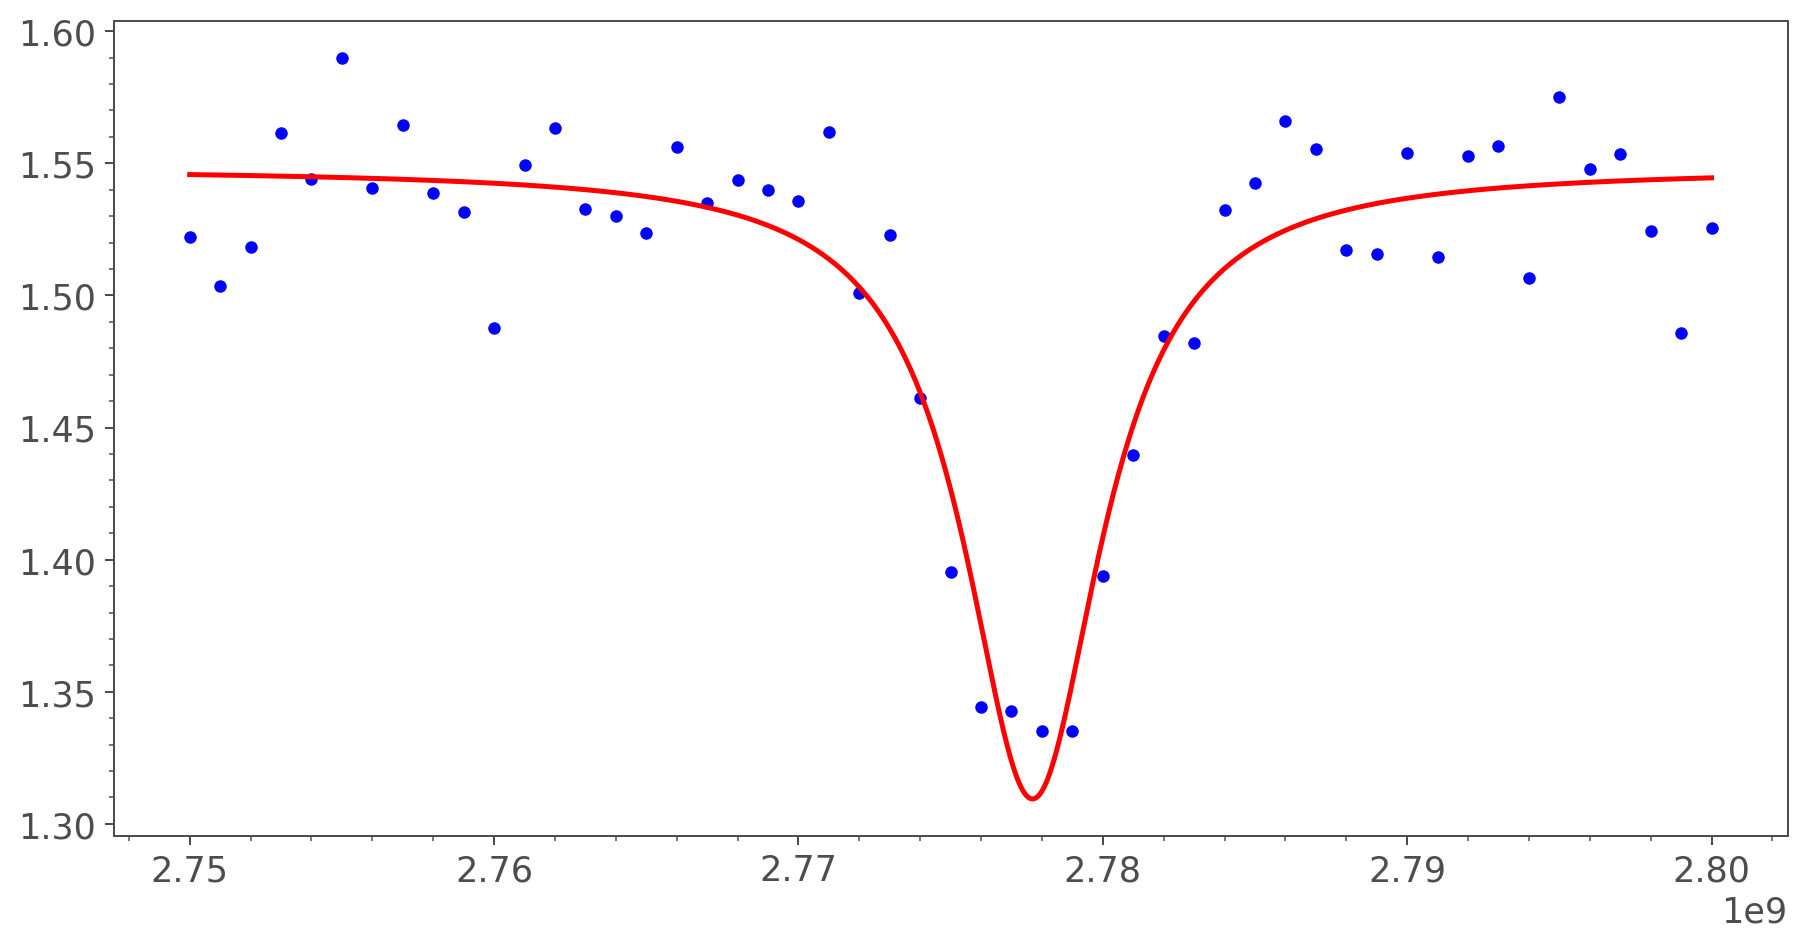

0.0036538606833204372 T


In [34]:
#Analyse bias field
#Gathering data from dictonary
directory = 'G:\\Data\\Qudi_Data\\2023\\09\\20230920\\PODMR\\'
podrm_path = directory + '20230920-2028-35_Set_A_3.1K_8mT_OOP_FC_OOC_ODMR_data_ch0_range0'+'.dat'
data_raw = np.loadtxt(podrm_path).T
var_list,data = (data_raw[0],data_raw[1])

gyro_nv = 28e9 #in Hz/T
e_field = 0 #in Hz
zero_field = 2.88e9 #in Hz, watch the Temperature

mode = ''
gslac = False
left = True

#Determine fit

if mode == 'double':
    fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_dip)
    lm,_ = fitlogic.make_lorentziandouble_model()
    
elif mode == 'N15':
    fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_N15)
    lm,_ = fitlogic.make_lorentziandouble_model()
    
elif mode == 'N14':
    fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_N14)
    lm,_ = fitlogic.make_lorentziandouble_model()
    
else:    
    fit = afm_scanner_logic._fitlogic.make_lorentzian_fit(var_list,data,estimator=afm_scanner_logic._fitlogic.estimate_lorentzian_dip)
    lm,_ = fitlogic.make_lorentzian_model()

# print(fit.fit_report())
bias_res_freq = fit.params['center'].value

if gslac == True and left == True:
    b_field_bias = np.sqrt(abs(bias_res_freq + zero_field)**2 - e_field**2) / gyro_nv
else:
    b_field_bias = np.sqrt(abs(bias_res_freq - zero_field)**2 - e_field**2) / gyro_nv

#Plot Data an
plt.plot(var_list,data,'bo')

x = np.linspace(var_list[0],var_list[-1],10000, endpoint=True)
plt.plot(x, lm.eval(fit.params, x=x),'r-')

plt.show()
print(b_field_bias,'T')

## Calculate B field from tracked res. freq. - 2D array

In [35]:
res_freq = qafm_data['fit_param_fw']['data']

gyro_nv = 28e9 #in Hz/T
e_field = 0 #in Hz
zero_field = 2.88e9 #in Hz, watch the Temperature

gslac = False
left = True

if gslac == True and left == True:
    b_field = np.sqrt(abs(res_freq + zero_field)**2 - e_field**2) / gyro_nv
else:
    b_field = np.sqrt(abs(res_freq - zero_field)**2 - e_field**2) / gyro_nv

## Plot B field uncorrected - Bnv

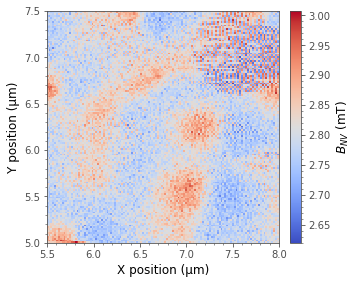

In [6]:
#Plot analysed Data from PODMR
x = (qafm_data['Height(Dac)_fw']['coord0_arr'])*10**6
y = (qafm_data['Height(Dac)_fw']['coord1_arr'])*10**6

plt.rcParams['figure.figsize'] = (5, 5)
fontsize = 12

low_centile = 0
high_centile = 100
data = (b_field)*10**3
im = plt.pcolormesh(x,y,data,cmap=plt.cm.get_cmap('coolwarm'), vmin =np.nanpercentile(data, low_centile), vmax = np.nanpercentile(data, high_centile))
plt.xlabel('X position (\u03BCm)',fontsize = fontsize)
plt.ylabel('Y position (\u03BCm)',fontsize = fontsize)

ax = plt.gca()
ax.set_aspect('equal')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='$B_{NV}$ (mT)', size=fontsize)

plt.tight_layout()

plt.show()

## Plot corrected B field - Bnv - Bbias

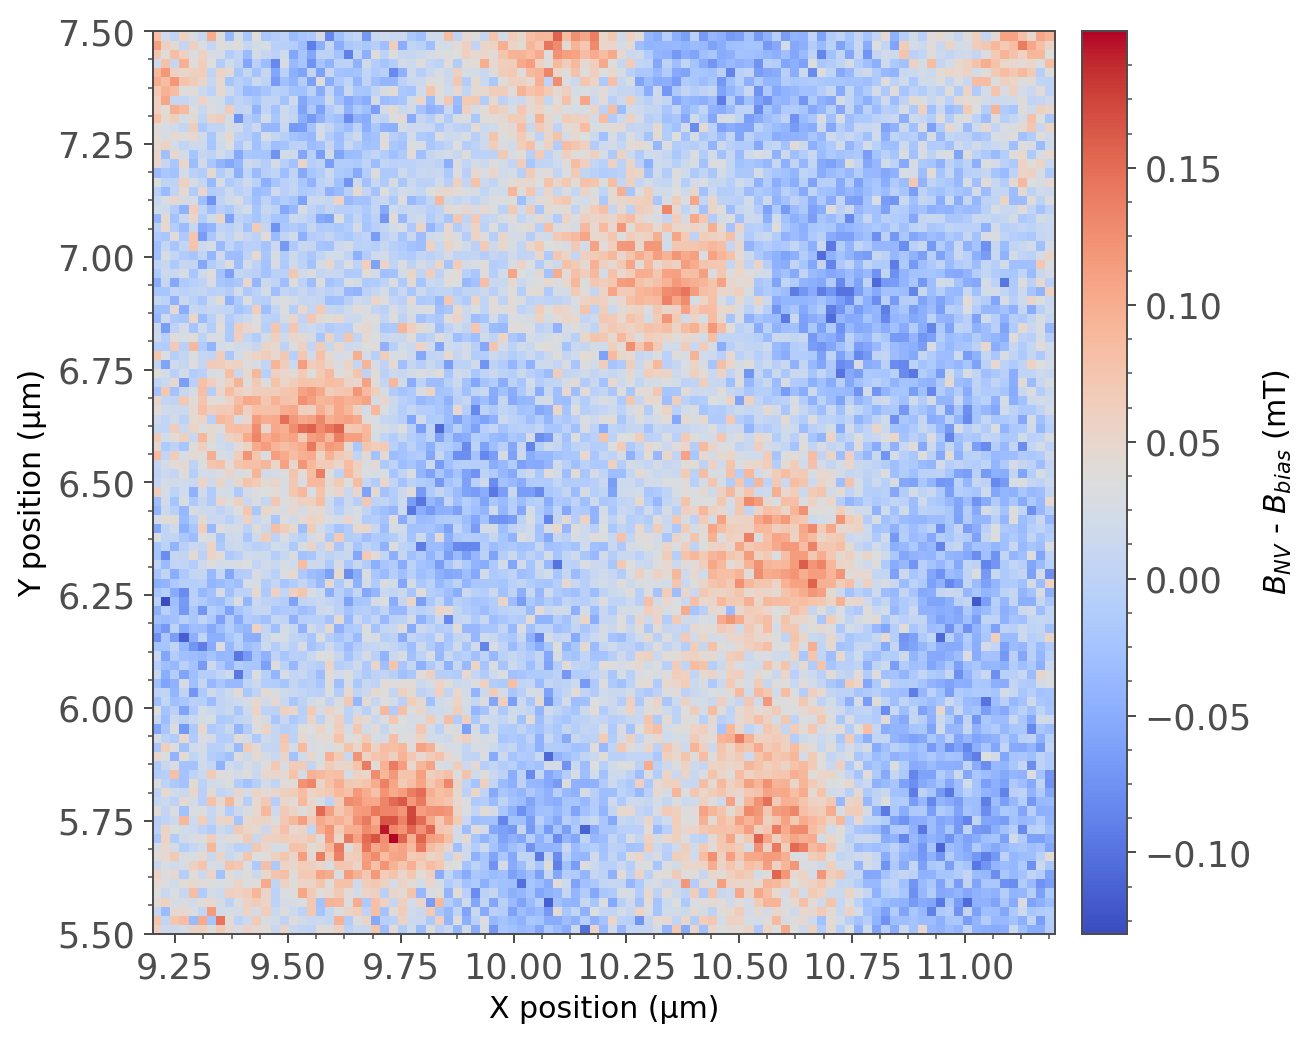

In [36]:
#Plot analysed Data from PODMR
x = (qafm_data['Height(Dac)_fw']['coord0_arr'])*10**6
y = (qafm_data['Height(Dac)_fw']['coord1_arr'])*10**6

#plt.rcParams['figure.figsize'] = (5, 5)
fontsize = 12

low_centile = 0
high_centile = 100
data = (b_field-b_field_bias)*10**3
im = plt.pcolormesh(x,y,data,cmap=plt.cm.get_cmap('coolwarm'), vmin =np.nanpercentile(data, low_centile), vmax = np.nanpercentile(data, high_centile))
plt.xlabel('X position (\u03BCm)',fontsize = fontsize)
plt.ylabel('Y position (\u03BCm)',fontsize = fontsize)

ax = plt.gca()
ax.set_aspect('equal')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.15)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='$B_{NV}$ - $B_{bias}$ (mT)', size=fontsize)

plt.tight_layout()

plt.show()

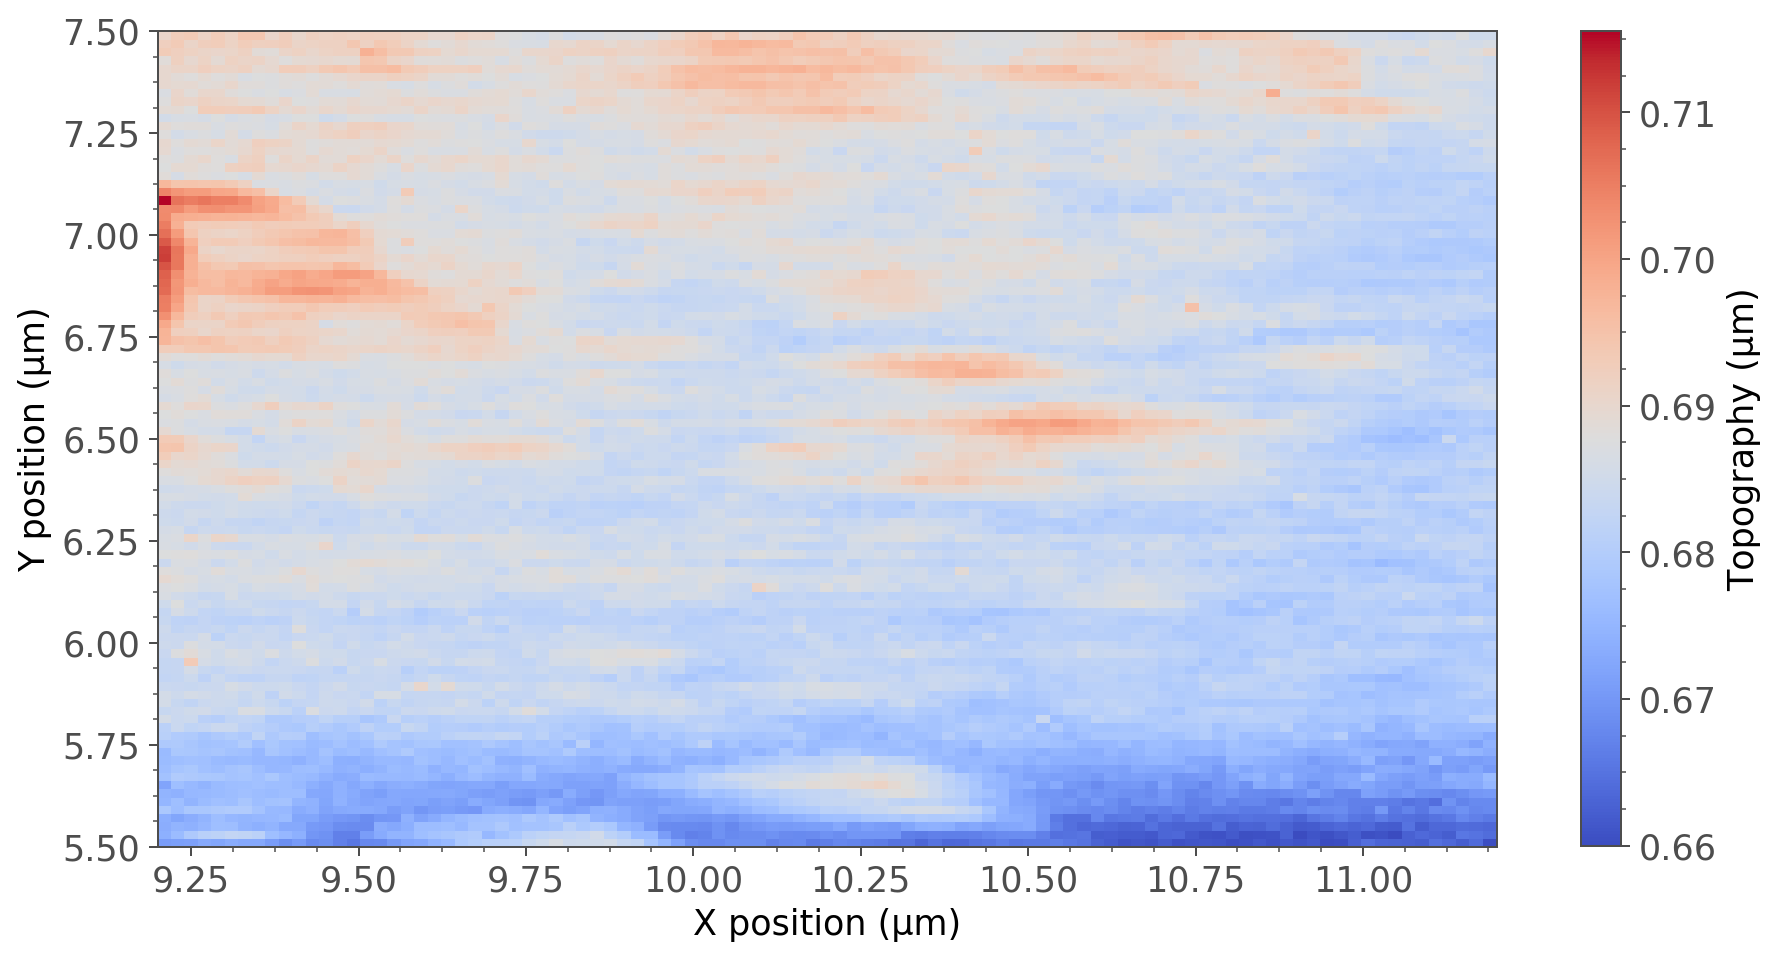

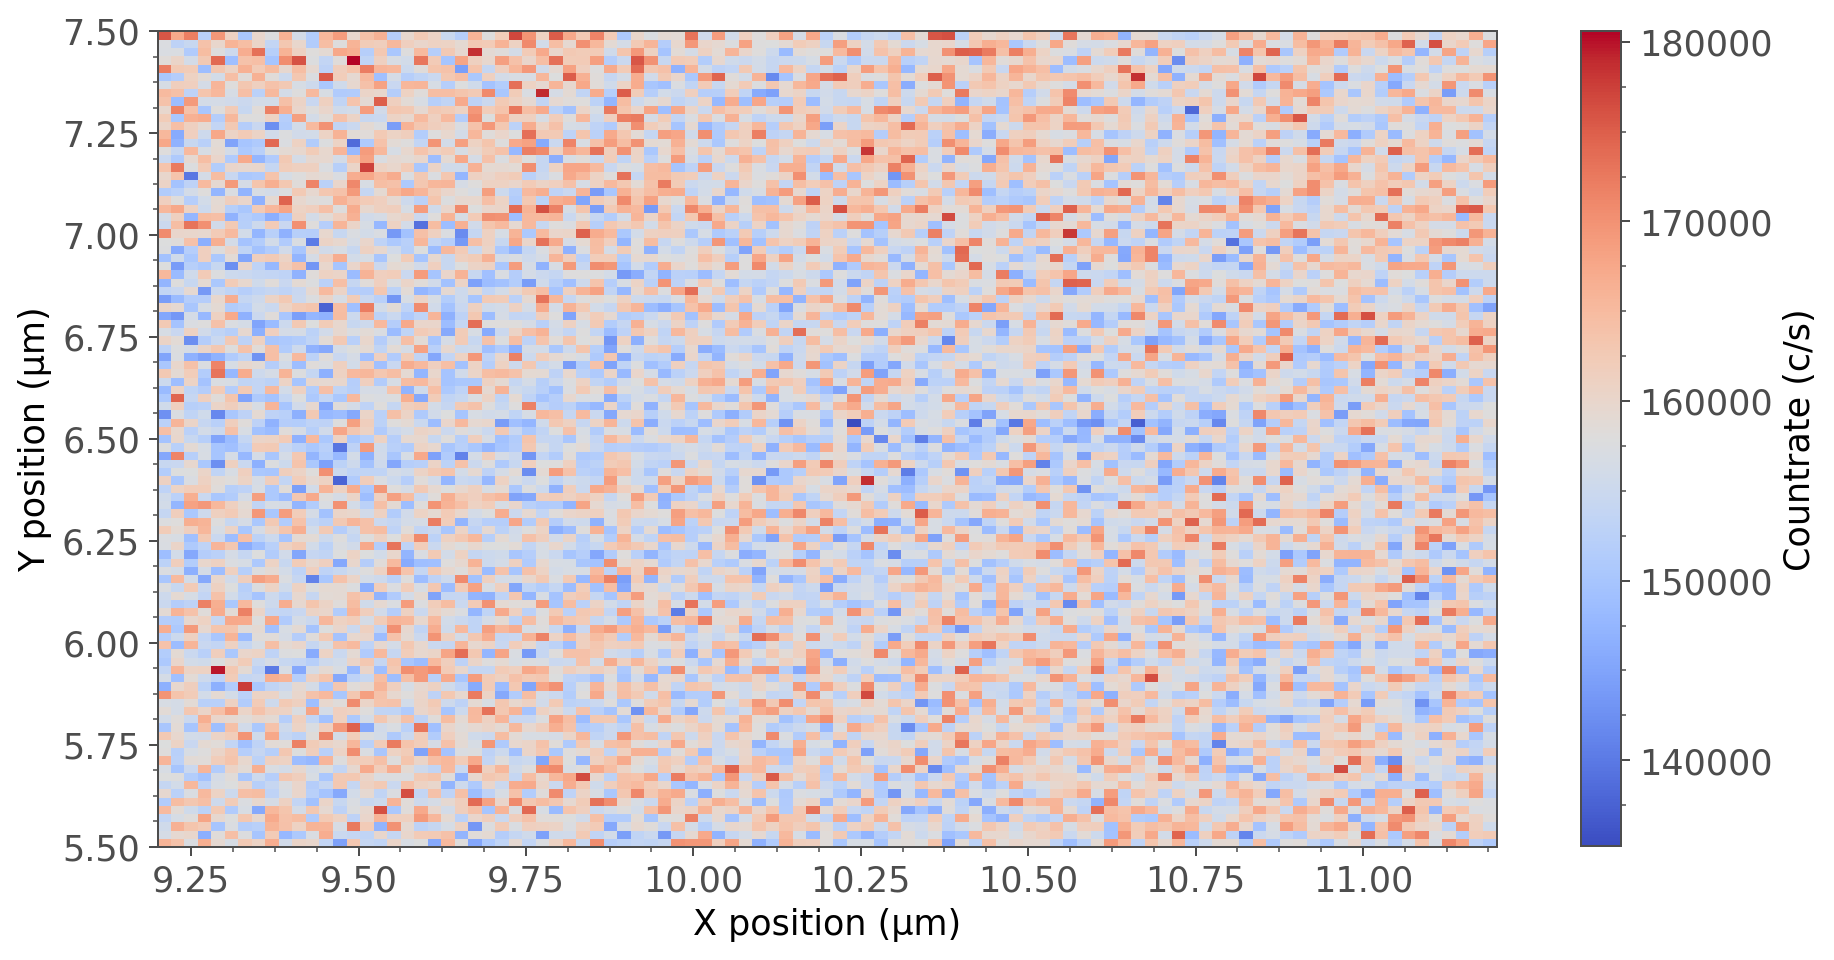

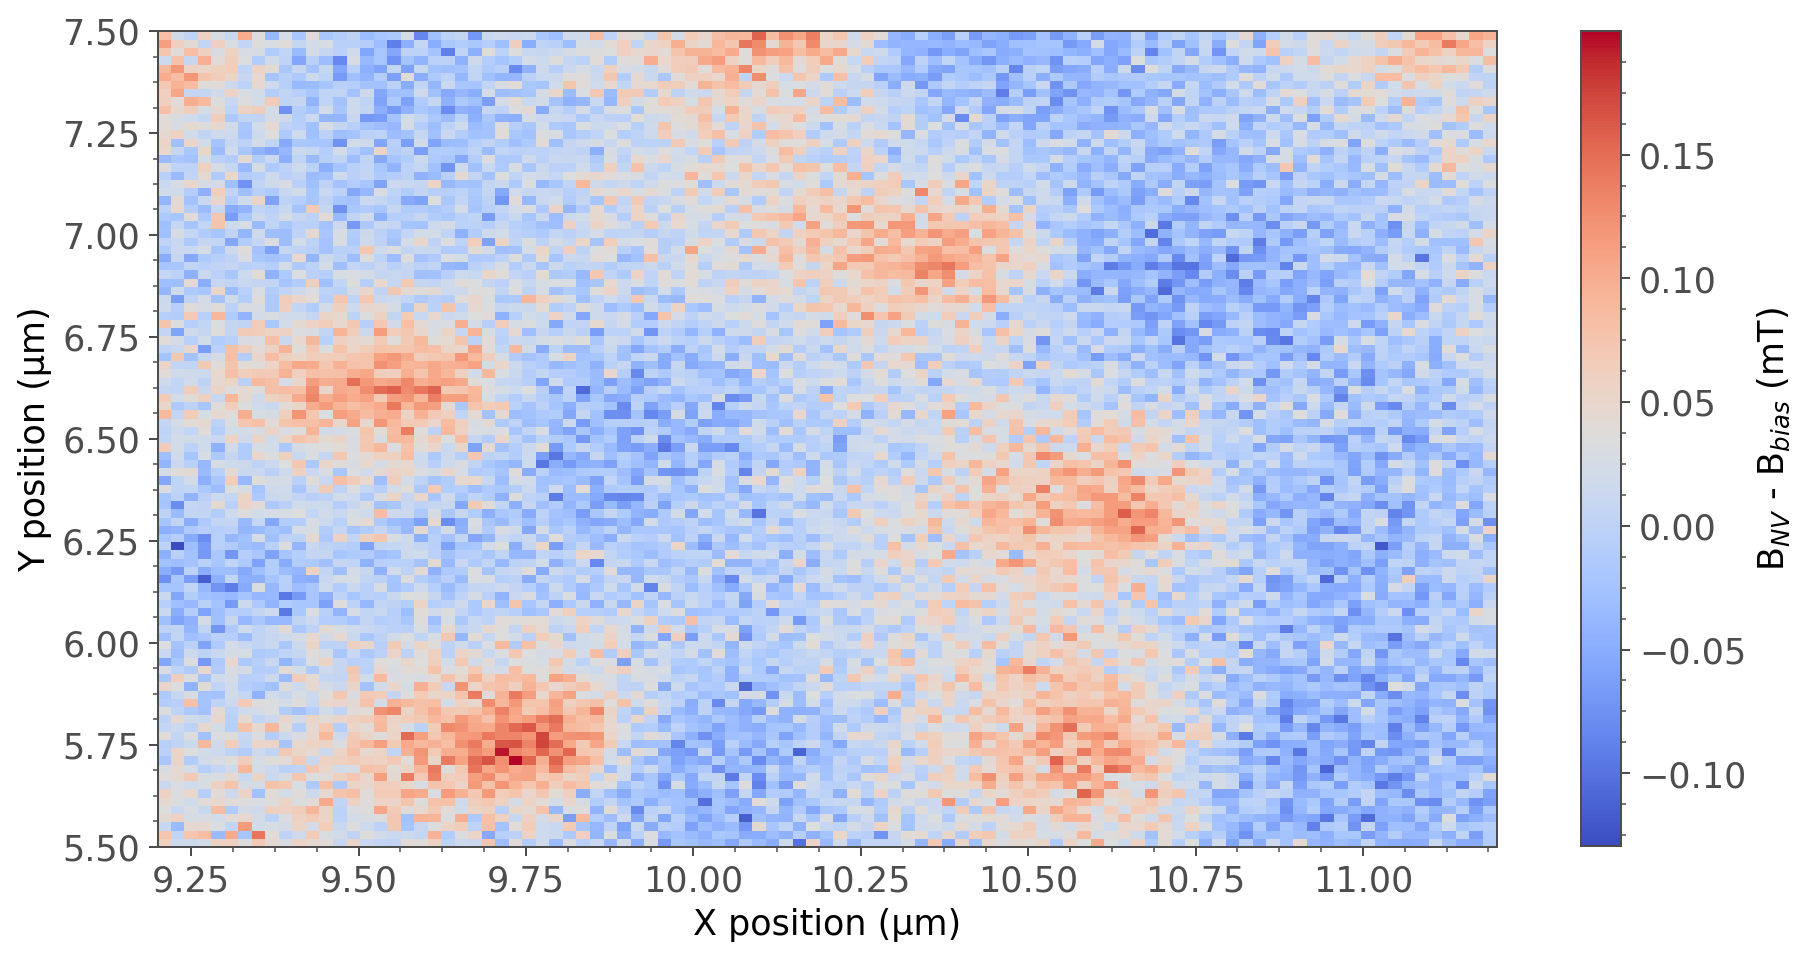

In [37]:
#Plot analysed Data from PODMR
x_gwy = qafm_data['Height(Dac)_fw']['coord0_arr']
y_gwy = qafm_data['Height(Dac)_fw']['coord1_arr']
x = x_gwy*10**6
y = y_gwy*10**6

#for gwyddion
dataobj = {}

## TOPO ##

low_centile = 0
high_centile = 100
data = qafm_data['Height(Dac)_fw']['data']*10**6
plt.pcolormesh(x,y,data,cmap=plt.cm.get_cmap('coolwarm'), vmin =np.nanpercentile(data, low_centile), vmax = np.nanpercentile(data, high_centile))
plt.xlabel('X position (\u03BCm)')
plt.ylabel('Y position (\u03BCm)')
plt.colorbar(label = 'Topography (\u03BCm)')
plt.show()
#for gwyddion
dataobj['Topography'] = {
                            'coord0_arr':x_gwy,
                            'coord1_arr':y_gwy,
                            'data':qafm_data['Height(Dac)_fw']['data'],
                            'params': {'coord0_start': x_gwy[0],'coord0_stop': x_gwy[-1],'coord1_start': y_gwy[0],'coord1_stop': y_gwy[-1]},
                            'xy_units': 'm',                                                
                            'si_units': 'm',
                            'nice_name': 'Topography'
    
                        }
## COUNTS ##

low_centile = 0
high_centile = 100
data = qafm_data['counts_fw']['data']
plt.pcolormesh(x,y,data,cmap=plt.cm.get_cmap('coolwarm'), vmin =np.nanpercentile(data, low_centile), vmax = np.nanpercentile(data, high_centile))
plt.xlabel('X position (\u03BCm)')
plt.ylabel('Y position (\u03BCm)')
plt.colorbar(label = 'Countrate (c/s)')
plt.show()
#for gwyddion
dataobj['Fluorescence'] = {
                            'coord0_arr':x_gwy,
                            'coord1_arr':y_gwy,
                            'data':qafm_data['counts_fw']['data'],
                            'params': {'coord0_start': x_gwy[0],'coord0_stop': x_gwy[-1],'coord1_start': y_gwy[0],'coord1_stop': y_gwy[-1]},
                            'xy_units': 'm',                                                
                            'si_units': 'c/s',
                            'nice_name': 'Fluorescence'
    
                        }
## RES FREQ ##

# low_centile = 0.75
# high_centile = 99.8
# data = res_freq/10**9
# plt.pcolormesh(x,y,data,cmap=plt.cm.get_cmap('coolwarm'), vmin =np.nanpercentile(data, low_centile), vmax = np.nanpercentile(data, high_centile))
# plt.xlabel('X position (\u03BCm)')
# plt.ylabel('Y position (\u03BCm)')
# plt.colorbar(label = 'Frequency (GHz)')
# plt.show()


## BFIELD CORR mT ##

low_centile = 0
high_centile = 100
data = b_field*10**3 -b_field_bias*10**3 # b_field_bias is found earlier from OOC fit. In tesla
plt.pcolormesh(x,y,data,cmap=plt.cm.get_cmap('coolwarm'), vmin =np.nanpercentile(data, low_centile), vmax = np.nanpercentile(data, high_centile))
plt.xlabel('X position (\u03BCm)')
plt.ylabel('Y position (\u03BCm)')
plt.colorbar(label = 'B$_{NV}$ - B$_{bias}$ (mT)')
plt.show()
#for gwyddion
dataobj['Stray Field'] = {
                            'coord0_arr':x_gwy,
                            'coord1_arr':y_gwy,
                            'data':b_field-b_field_bias,
                            'params': {'coord0_start': x_gwy[0],'coord0_stop': x_gwy[-1],'coord1_start': y_gwy[0],'coord1_stop': y_gwy[-1]},
                            'xy_units': 'm',                        
                            'si_units': 'T',
                            'nice_name': 'Stray Field: B_NV - B_bias'
    
                        }


## 5.a Save to new gwyddion file - data defined in previous cell

In [38]:
"""save_obj_to_gwyddion(): writes qudi data object to Gwyddion file
        input:  
        - dataobj: proteusQ data object of from dataobj['data_key']
        - filename: file path to save object
        - prefix:  name to be prefixed to all head objects

        requirements:
        dataobj['scan_type'] must contain keys {coord0[], coord1[], data[,], params[coord0-1_start-stop], si_units, nice_name}
    """
from logic import gwyfile as gwy
save_obj_to_gwyddion(dataobj=dataobj,filename=filepath+'QAFM_jupyter_corrected.gwy')

## 5.a.i. Save data to Gwyddion function

In [10]:
def save_obj_to_gwyddion(dataobj,filename,gwytypes=['image']):
    """save_obj_to_gwyddion(): writes qudi data object to Gwyddion file
        input:  
        - dataobj: proteusQ data object of from dataobj['data_key']
        - filename: file path to save object
        - prefix:  name to be prefixed to all head objects

        requirements:
        dataobj['scan_type'] must contain keys {coord0[], coord1[], data[,], params[coord0-1_start-stop], si_units, nice_name}
    """

    # check for existance of valid object names
    datakeys = list(dataobj.keys())

    # overall object container
    objout = gwy.objects.GwyContainer()

    for dataki,datak in enumerate(sorted(datakeys, key=str.lower)):
        meas = dataobj[datak]

        # check that data is valid
        if not {'coord0_arr','coord1_arr','data'}.issubset(set(meas.keys())):
            continue 

        # check that there is non-trivial data (skip empty measurements)
        if np.sum(meas['data']) == 0.0:
            continue

        # transform data
        #scalefactor = meas['scale_fac']
        coord0 = meas['coord0_arr']
        coord1 = meas['coord1_arr']
        data_si = meas['data'] #* scalefactor

        params = meas['params']
        coord0_start = next(k for k in params.keys() if k.startswith('coord0_start'))
        coord0_stop = next(k for k in params.keys() if k.startswith('coord0_stop'))
        coord1_start = next(k for k in params.keys() if k.startswith('coord1_start'))
        coord1_stop = next(k for k in params.keys() if k.startswith('coord1_stop'))

        xy_units = meas['xy_units']
        z_units = meas['si_units']
        measname = datak + ":" + meas['nice_name']

        # encode to image
        img = gwy.objects.GwyDataField(data=data_si, si_unit_xy=xy_units, si_unit_z=z_units)
        img.xoff = params[coord0_start]
        img.xreal = params[coord0_stop] - params[coord0_start]
        img.yoff = params[coord1_start]
        img.yreal = params[coord1_stop] - params[coord1_start]

        # add to parent object 
        if 'image' in gwytypes: 
            # image types
            basekey = '/' + str(dataki) + '/data'
            objout[basekey + '/title'] = measname
            objout['/' + str(dataki) + '/base/palette'] = 'Sky'
            objout[basekey] = img
            # comment meta data
            if meas['params']:
                d = {key: str(val) for key, val in meas['params'].items()}
                meta = gwy.objects.GwyContainer(d)
                objout['/' + str(dataki) + '/meta'] = meta

    # write out file    
    if objout:
        objout.tofile(filename)

## Saved images in multiple formats - matplotlib style

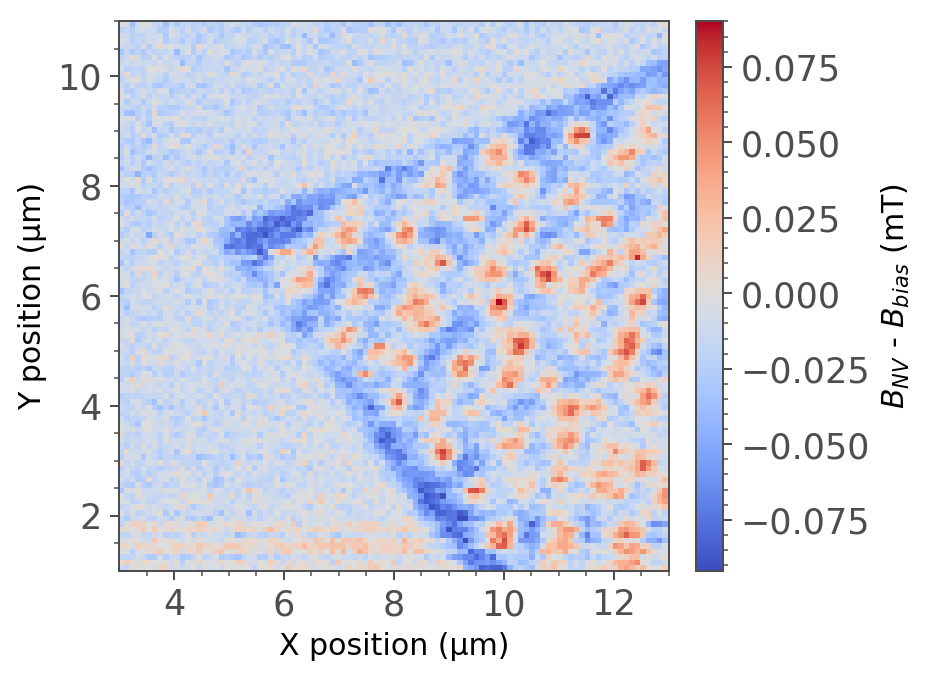

In [47]:
#Save b field image in Gauss
x = (qafm_data['Height(Dac)_fw']['coord0_arr'])*10**6
y = (qafm_data['Height(Dac)_fw']['coord1_arr'])*10**6

plt.rcParams['figure.figsize'] = (5, 4)
fontsize = 12

low_centile = 0
high_centile = 100
data = (b_field-b_field_bias)*10**3
im = plt.pcolormesh(x,y,data,cmap=plt.cm.get_cmap('coolwarm'), vmin =np.nanpercentile(data, low_centile), vmax = np.nanpercentile(data, high_centile))
plt.xlabel('X position (\u03BCm)',fontsize = fontsize)
plt.ylabel('Y position (\u03BCm)',fontsize = fontsize)

ax = plt.gca()
ax.set_aspect('equal')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.15)
cbar = plt.colorbar(im, cax=cax, use_gridspec=True)
cbar.set_label(label='$B_{NV}$ - $B_{bias}$ (mT)', size=fontsize)

plt.tight_layout()

with open(filepath+'QAFM_b_field_fw_fig_corrected.png', 'wb') as f:
    plt.savefig(f,format='png')
with open(filepath+'QAFM_b_field_fw_fig_corrected.pdf', 'wb') as f:
    plt.savefig(f,format='pdf')
with open(filepath+'QAFM_b_field_fw_fig_corrected.svg', 'wb') as f:
    plt.savefig(f,format='svg')

plt.show()